In [37]:
import cm1.input.sounding
import cm1.input.era5
from cm1.util import TMPDIR
from cm1.skewt import skewt
import matplotlib.pyplot as plt
import pandas as pd
from metpy.units import units
from metpy.calc.thermo import (
    mixing_ratio,
    saturation_vapor_pressure,
    vapor_pressure,
    dewpoint,
)
import logging
import scipy.optimize
import numpy as np
import metpy.constants as mpconsts

In [43]:
def lcl(pressure, temperature, dewpoint, max_iters=50, eps=1e-5):
    r"""Calculate the lifted condensation level (LCL) from the starting point.

    The starting state for the parcel is defined by `temperature`, `dewpoint`,
    and `pressure`. If these are arrays, this function will return a LCL
    for every index. This function does work with surface grids as a result.

    Parameters
    ----------
    pressure : `pint.Quantity`
        Starting atmospheric pressure

    temperature : `pint.Quantity`
        Starting temperature

    dewpoint : `pint.Quantity`
        Starting dewpoint

    Returns
    -------
    `pint.Quantity`
        LCL pressure

    `pint.Quantity`
        LCL temperature

    Other Parameters
    ----------------
    max_iters : int, optional
        The maximum number of iterations to use in calculation, defaults to 50.

    eps : float, optional
        The desired relative error in the calculated value, defaults to 1e-5.

    Examples
    --------
    >>> from metpy.calc import lcl
    >>> from metpy.units import units
    >>> lcl(943 * units.hPa, 33 * units.degC, 28 * units.degC)
    (<Quantity(877.563323, 'hectopascal')>, <Quantity(26.7734921, 'degree_Celsius')>)

    See Also
    --------
    parcel_profile

    Notes
    -----
    This function is implemented using an iterative approach to solve for the
    LCL. The basic algorithm is:

    1. Find the dewpoint from the LCL pressure and starting mixing ratio
    2. Find the LCL pressure from the starting temperature and dewpoint
    3. Iterate until convergence

    The function is guaranteed to finish by virtue of the `max_iters` counter.

    .. versionchanged:: 1.0
       Renamed ``dewpt`` parameter to ``dewpoint``

    """

    def _lcl_iter(p, p0, w, t):
        nonlocal nan_mask
        td = globals()["dewpoint"]._nounit(vapor_pressure._nounit(p, w))
        p_new = p0 * (td / t) ** (1.0 / mpconsts.nounit.kappa)
        print(p_new)
        nan_mask = nan_mask | np.isnan(p_new)
        return np.where(np.isnan(p_new), p, p_new)

    # Handle nans by creating a mask that gets set by our _lcl_iter function if it
    # ever encounters a nan, at which point pressure is set to p, stopping iteration.
    nan_mask = False
    w = mixing_ratio._nounit(saturation_vapor_pressure._nounit(dewpoint), pressure)
    lcl_p = scipy.optimize.fixed_point(
        _lcl_iter,
        pressure,
        args=(pressure, w, temperature),
        xtol=eps,
        maxiter=max_iters,
    )
    lcl_p = np.where(nan_mask, np.nan, lcl_p)

    # np.isclose needed if surface is LCL due to precision error with np.log in dewpoint.
    # Causes issues with parcel_profile_with_lcl if removed. Issue #1187
    lcl_p = np.where(np.isclose(lcl_p, pressure), pressure, lcl_p)

    return lcl_p, globals()["dewpoint"]._nounit(vapor_pressure._nounit(lcl_p, w))

In [48]:
p_parcel = 1014.8 * units.hPa
q_parcel = 18.65 * units.g / units.kg
Td_parcel = dewpoint(vapor_pressure(p_parcel, q_parcel))
print(Td_parcel)
T = (26.8 * units.degC).m_as("K")
lcl(p_parcel.m_as("Pa"), T, Td_parcel.m_as("K"))

23.838398542950813 degree_Celsius
98016.14607979181
97352.82554218156
97193.1926277347
97192.70037410116
97192.58099616927
97192.58099589255


(array(97192.58099583), np.float64(296.2732779027467))

In [15]:
help(mpconsts.nounit)

Help on module metpy.constants.nounit in metpy.constants:

NAME
    metpy.constants.nounit - Subset of constant and thermophysical property values expressed as floats in base units.

DATA
    Cp_d = 1004.6662184201462
    Cp_i = 2090.0
    Cp_l = 4219.400000000001
    Cp_v = 1860.078011865639
    Lf = 333700.0
    Ls = 2834540.0
    Lv = 2500840.0
    Rd = 287.04749097718457
    Rv = 461.52311572606084
    T0 = 273.16
    epsilon = 0.6219569100577033
    g = 9.80665
    kappa = 0.28571428571428564
    sat_pressure_0c = 611.2
    units = <pint.registry.ApplicationRegistry object>
    zero_degc = 273.15

FILE
    /glade/work/ahijevyc/conda-envs/cm1/lib/python3.12/site-packages/metpy/constants/nounit.py




In [1]:
import logging
import os
from pathlib import Path
import shutil

import cm1.input.sounding
from cm1.run import PBS, CM1Run
from cm1.utils import skewt
import f90nml
import metpy.calc as mpcalc
from metpy.units import units
import pandas as pd

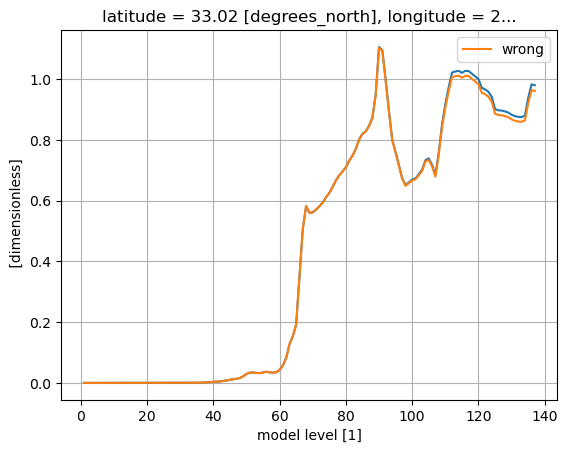

In [6]:
c, = (mpcalc.vapor_pressure(ds.P, mpcalc.mixing_ratio_from_specific_humidity(ds.Q)) / mpcalc.saturation_vapor_pressure(ds.T)).metpy.convert_to_base_units().plot()
c.axes.grid()
(mpcalc.vapor_pressure(ds.P, ds.Q) / mpcalc.saturation_vapor_pressure(ds.T)).metpy.convert_to_base_units().plot(ax=c.axes, label="wrong")
c.axes.legend()


970.7424492314431 hectopascal 21.748021100928042 degree_Celsius
5.580565243562764 joule / kilogram -300.8789177495114 joule / kilogram
5.580565243562764 joule / kilogram -306.30925046672394 joule / kilogram


/glade/derecho/scratch/ahijevyc/MetPy/src/metpy/interpolate/one_dimension.py:160: RuntimeWarning: invalid value encountered in divide
  var_interp = var[below] + (var[above] - var[below]) * ((x_array - xp[below])


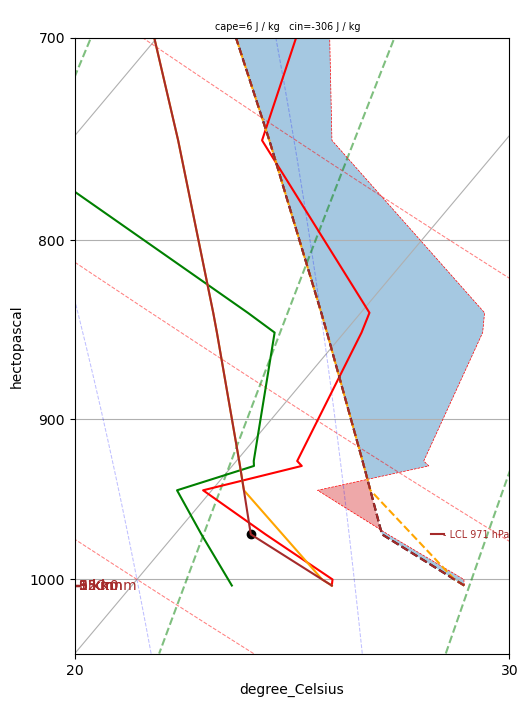

In [7]:
import matplotlib.pyplot as plt
import metpy
import metpy.calc as mpcalc
import numpy as np
import xarray
from metpy.testing import assert_almost_equal


def test_sensitive_sounding():
    """Test quantities for a sensitive sounding (#902)."""
    # This sounding has a very small positive area in the low level. It's only captured
    # properly if the parcel profile includes the LCL, otherwise it breaks LFC and CAPE
    p = units.Quantity([1004., 1000., 943., 928., 925., 850., 839., 749., 700., 699.,
                        603., 500., 404., 400., 363., 306., 300., 250., 213., 200.,
                        176., 150.], 'hectopascal')
    t = units.Quantity([24.6, 24.5, 19.8, 21.6, 21.4, 20.4, 20.2, 14.4, 13.2, 13., 6.8, -3.3,
                        -13.1, -13.7, -17.9, -25.5, -26.9, -37.9, -46.7, -48.7, -52.1, -58.9],
                       'degC')
    td = units.Quantity([22.3, 22.1, 19.2, 20.5, 20.4, 18.4, 17.4, 8.4, -2.8, -3.0, -15.2,
                         -20.3, -29.1, -27.7, -24.9, -39.5, -41.9, -51.9, -60.7, -62.7, -65.1,
                         -71.9], 'degC')
    ds = xarray.Dataset(
        dict(
            P=("level", p),
            T=("level", t),
            Td=("level", td),
            Z=("level", len(p) * [0] * units.m),
            U=("level", len(p) * [0] * units.m / units.s),
            V=("level", len(p) * [0] * units.m / units.s),
        ),
        coords={"level": p},
    )
    ds["Q"] = mpcalc.specific_humidity_from_dewpoint(ds["P"], ds["Td"])
    ds["surface_geopotential_height"] = 0
    ds["surface_geopotential_height"] *= units.m
    ds["SP"] = 1004
    ds["SP"] *= units.hPa

    ax = skewt(ds, ptop=700*units.hPa, fig=plt.figure(figsize=(10,8)), xlim=(20,30), rotation=40)
    lcl_pressure, lcl_temp = mpcalc.lcl(ds["P"], ds["T"], ds["Td"])
    lcl_pressure = lcl_pressure[0]
    lcl_temp = lcl_temp[0]
    print(lcl_pressure, lcl_temp.to("degC"))
    ax.plot(lcl_pressure, lcl_temp, 'ko', markerfacecolor='black')

    prof = mpcalc.parcel_profile(p, ds["T"][0], ds["Td"][0])
    prof_mixing_ratio = mpcalc.saturation_mixing_ratio(p, prof)
    parcel_mixing_ratio = mpcalc.saturation_mixing_ratio(
        ds["P"][0],
        ds["Td"][0],
    ) 
    prof_mixing_ratio[
        p >= lcl_pressure
    ] = parcel_mixing_ratio.item()  # unsaturated mixing ratio (constant up to LCL)
    # parcel virtual temperature
    profTv = mpcalc.virtual_temperature(prof, prof_mixing_ratio)
    ax.plot(p, prof, color="orange")
    ax.plot(p, profTv, color="orange", linestyle="dashed")
    pos, neg = mpcalc.cape_cin(p, ds["T"], ds["Td"], prof)
    print(pos, neg)

    # Calculate full parcel profile with LCL.
    p_without_lcl = p  # remember so we can interpolate other variables later
    # Append LCL to pressure array.
    p = np.append(p, lcl_pressure)
    # Create reverse sorted array of pressure. mpcalc assumes bottom-up arrays.
    p = np.sort(p)[::-1]
    # Interpolate other variables to p array (which now includes LCL).
    t, Td = metpy.interpolate.one_dimension.interpolate_1d(
        p,
        p_without_lcl,
        ds["T"],
        ds["Td"],
    )
    prof = mpcalc.parcel_profile(p, ds["T"][0], ds["Td"][0])
    prof_mixing_ratio = mpcalc.saturation_mixing_ratio(p, prof)
    parcel_mixing_ratio = mpcalc.saturation_mixing_ratio(
        ds["P"][0],
        ds["Td"][0],
    ) 
    prof_mixing_ratio[
        p >= lcl_pressure
    ] = parcel_mixing_ratio.item()  # unsaturated mixing ratio (constant up to LCL)
    # parcel virtual temperature
    profTv = mpcalc.virtual_temperature(prof, prof_mixing_ratio)
    ax.plot(p, prof, color="brown")
    ax.plot(p, profTv, color="brown", linestyle="dashed")

    pos, neg = mpcalc.cape_cin(p, t, Td, prof)
    print(pos, neg)

test_sensitive_sounding()

970.7113556117489 hectopascal 21.349157267204703 degree_Celsius


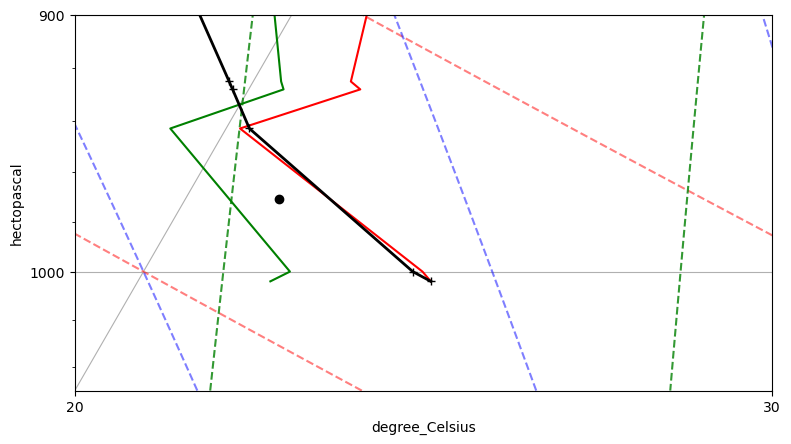

In [9]:
import matplotlib.pyplot as plt
import numpy as np

from metpy.plots import SkewT
from metpy.units import units

p = np.array([1004.,  1000.,   943.,   928.,   925.,   850.,   839.,   749.,   700.,   699.,
              603.,   500.,   404.,   400.,   363.,   306.,   300.,   250.,   213.,   200.,
              176.,   150.,   120.,   105.,   100.,    70.,    66.,    58.,    50.,    40.,
              33.,    30.,    23.,    20.,    16.]) * units('hPa')

T = np.array([24.2,  24.,   20.2,  21.6,  21.4,  20.4,  20.2,  14.4,  13.2,  13.,    6.8,  -3.3,
              -13.1, -13.7, -17.9, -25.5, -26.9, -37.9, -46.7, -48.7, -52.1, -58.9, -67.3, -66.5,
              -66.7, -65.1, -66.1, -60.9, -60.5, -57.7, -50.1, -50.3, -50.1, -47.9, -43.1])  \
              * units('degC')

Td = np.array([2.19000000e+01,   2.21000000e+01,   1.92000000e+01,   2.05000000e+01,
               2.04000000e+01,   1.84000000e+01,   1.74000000e+01,   8.40000000e+00,
               -2.80000000e+00,  -3.00000000e+00,  -1.52000000e+01,  -2.03000000e+01,
               -2.91000000e+01,  -2.77000000e+01,  -2.49000000e+01,  -3.95000000e+01,
               -4.19000000e+01,  -5.19000000e+01,  -6.07000000e+01,  -6.27000000e+01,
               -6.51000000e+01,  -7.19000000e+01,   9.99999000e+05,   9.99999000e+05,
               9.99999000e+05,   9.99999000e+05,   9.99999000e+05,   9.99999000e+05,
               9.99999000e+05,   9.99999000e+05,   9.99999000e+05,   9.99999000e+05,
               9.99999000e+05,   9.99999000e+05,   9.99999000e+05]) * units('degC')

Td[Td.m>9e5] = -68 * units('degC')

# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.ax.set_ylim(1050, 900)
skew.ax.set_xlim(20, 30)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', marker="+", linewidth=2)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()